# Simulation Run Log Analysis and Visualization for AWS DeepRacer

This notebook walks through how you can analyze and debug using the AWS DeepRacer Simulation logs 

```
1. Tools to find best iteration of your model
2. Visualize reward distribution on the track
  2.1 Visualize reward heatmap per episode or iteration
3. Identify hotspots on the track for your model
4. Understand probability distributions on simulated images
5. Evaluation run analysis - plot lap speed heatmap
```

## Requirements

boto3 >= 1.9.133  ; configure your aws cli and/or boto credentials file

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [2]:
#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

In [3]:
from log_analysis import *
import cw_utils

In [4]:
# Make sure your boto version is >= '1.9.133'
cw_utils.boto3.__version__

'1.9.210'

In [5]:
#print log files and show most recent. You may want to use that file for analysis
import os
file_list = []
for file in os.listdir("logs"):
    if(file=="latest"):
        continue
    file_list.append([os.stat(os.path.join("logs", file)).st_mtime, os.path.join("logs", file)])
    file_list.sort(key=lambda x: x[0])  # sort by creation date
    #print(file + "   :   " + str(os.stat(os.path.join("logs", file)).st_mtime))
#print("\nMost recent file  = " + file_list[-1][1])
#fname = file_list[-1][1]

### Download the desired log file given the simulation ID 


If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3 :: 
https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html

In [6]:
## CHANGE This to your simulation application ID
AWS_train_ID = 'sim-pnc07l4nl50w' 
AWS_eval_ID = 'sim-ggk3wzd57650'
##--------------------------------

stream_name = AWS_train_ID 
fname = 'logs/deepracer-%s.log' %stream_name
cw_utils.download_log(fname, stream_prefix=stream_name)

Log file exists, use force=True to download again


In [7]:
!tail -n 3 $fname

SIM_TRACE_LOG:173,93,0.6480,3.5503,-2.1262,0.52,1.00,9,0.8846,False,True,10.5793,53,17.67,1569290015.9795809
SIM_TRACE_LOG:173,94,0.6399,3.5348,-2.1174,-0.26,0.50,2,0.5533,False,True,10.6684,53,17.67,1569290016.0517664
SIM_TRACE_LOG:173,95,0.6336,3.5240,-2.1150,-0.52,0.50,0,0.4427,False,True,10.6684,53,17.67,1569290016.1091778


## Load waypoints for the track you want to run analysis on

```Tracks Available::
AWS_track                Straight_track                Oval_track
Bowtie_track             H_track                       reinvent_base
```

In [8]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)
    
waypoints = get_track_waypoints("reinvent_base") ### re:invent track
waypoints.shape

(71, 6)

## Visualize the Track and Waypoints

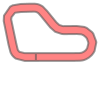

In [9]:
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

road_poly

In [10]:
# rescale waypoints to centimeter scale

center_line = waypoints[:,0:2] *100
inner_border = waypoints[:,2:4] *100
outer_border = waypoints[:,4:6] *100

# Helper Functions 

In [11]:
def plot_track(df, track_size=(500, 800), x_offset=0, y_offset=0):
    '''
    Each track may have a diff track size, 
    For reinvent track, use track_size=(500, 800)
    Tokyo, track_size=(700, 1000)
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''
    track = np.zeros(track_size) # lets magnify the track by *100
    for index, row in df.iterrows():
        x = int(row["x"]) + x_offset
        y = int(row["y"]) + y_offset
        reward = row["reward"]
        
        track[y,x] = reward 
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return track

In [12]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1*100, car_x2*100], [y1*100, car_y2*100], 'b.')
        
    return fig

## Load the training log

In [13]:
data = load_data(fname)

In [14]:
df = convert_to_pandas(data)
df.head()

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp
0,1,0,0,305.00,68.32,0.0004,0.00,0.0,0.0,0.0000,0,True,0.7922,0,17.67,1569286447.4683766
1,1,0,1,305.00,68.32,0.0001,0.26,0.5,6.0,0.5040,0,True,0.7923,0,17.67,1569286447.5435104
2,1,0,2,305.18,68.18,-0.0098,-0.26,1.0,3.0,1.0080,0,True,0.8024,0,17.67,1569286447.6048925
3,1,0,3,305.45,67.98,-0.0246,0.52,1.0,9.0,0.8065,0,True,0.8175,0,17.67,1569286447.6756775
4,1,0,4,305.52,67.91,-0.0301,0.26,0.5,6.0,0.5041,0,True,0.8218,0,17.67,1569286447.7387812


In [15]:
df['y'].min(), df['y'].max()

(22.59, 496.54999999999995)

In [16]:
df[['iteration','episode','steps','x','y','throttle','reward','progress','track_len']].describe()

,iteration,episode,steps,x,y,throttle,reward,progress,track_len
count,30948.000000,30948.000000,30948.000000,30948.000000,30948.000000,30948.000000,30948.000000,30948.000000,3.094800e+04
mean,5.907167,107.456605,149.212292,380.532908,220.026528,0.765429,0.673425,14.979388,1.767000e+01
std,2.378262,47.584703,153.551045,231.669571,147.159147,0.255098,0.413258,14.901396,3.382238e-12
min,1.000000,0.000000,0.000000,26.900000,22.590000,0.000000,0.000000,0.762900,1.767000e+01
25%,4.000000,73.000000,44.000000,147.795000,71.467500,0.500000,0.439300,4.654275,1.767000e+01
50%,6.000000,119.000000,100.000000,370.770000,189.330000,1.000000,0.618450,10.076900,1.767000e+01
75%,8.000000,148.000000,202.000000,601.005000,362.342500,1.000000,1.031100,20.149700,1.767000e+01
max,9.000000,173.000000,1030.000000,773.150000,496.550000,1.000000,2.000000,100.000000,1.767000e+01


In [17]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import  MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1))
df['reward'] = pd.DataFrame(scaled_vals.squeeze())


In [18]:
df['reward'].min(), df['reward'].max()

(0.0, 1.0)

## Plot rewards per Iteration

This graph is useful to understand the mean reward and standard deviation within each episode 

Number of episodes =  173


Text(0.5, 0, 'Episode')

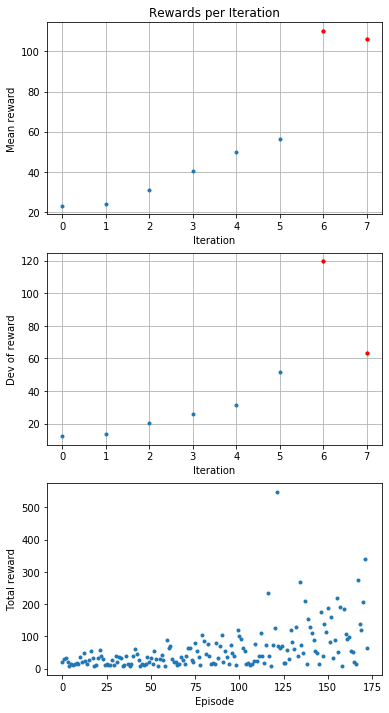

In [19]:
REWARD_THRESHOLD = 100

# reward graph per episode
min_episodes = np.min(df['episode'])
max_episodes = np.max(df['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
for epi in range(min_episodes, max_episodes):
    df_slice = df[df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == 20:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')

ax.set_ylabel('Dev of reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_ylabel('Total reward')
ax.set_xlabel('Episode')

## Analyze the reward distribution for your reward function

In [20]:
# add y_offset to bring everything to the positive axis

y_offset = int(df['y'].min())
if y_offset > 0: # if positive, just keep it the same
    y_offset = 0
y_offset = abs(y_offset)

inner_border[:,1] = inner_border[:,1] + y_offset
center_line[:,1] = center_line[:,1] + y_offset
outer_border[:,1] = outer_border[:,1] + y_offset

In [21]:
#NOTE: For the Tokyo track use this dimentions

#track = plot_track(df, track_size=(700, 1000), x_offset=0, y_offset=y_offset)
#plt.title("Reward distribution for all actions ")
#im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

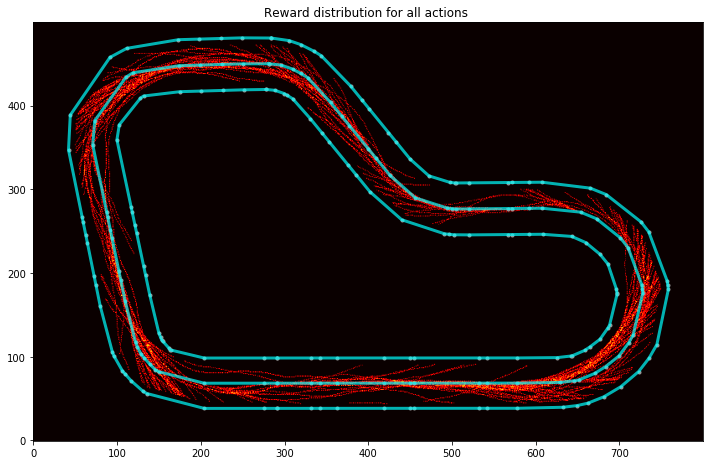

In [22]:
track = plot_track(df)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

### Plot a particular iteration


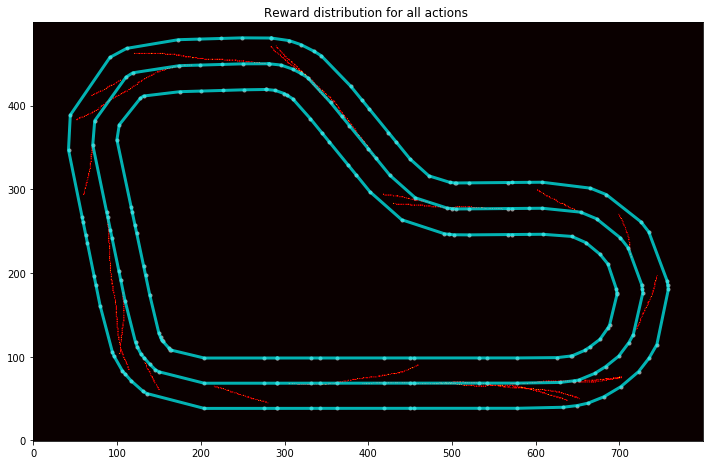

In [23]:
iteration_id = 2
track = plot_track(df[df['iteration'] == iteration_id])
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

### Path taken for top reward iterations

NOTE: in a single episode, the car can go around multiple laps, the episode is terminated when car completes 1000 steps

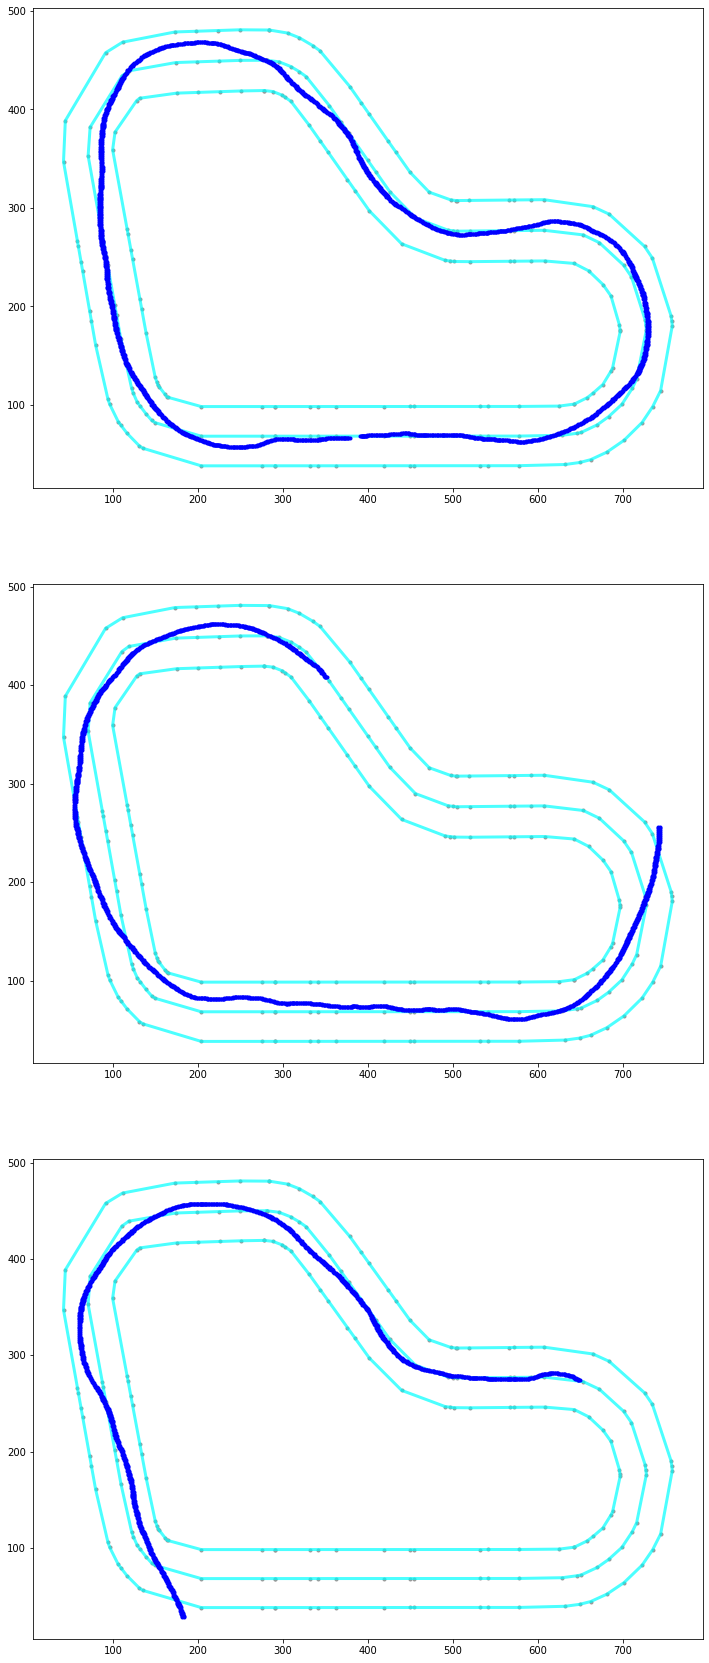

In [24]:
action_map, episode_map, sorted_idx = episode_parser(data)    
fig = plot_top_laps(sorted_idx[:], 3)

### Path taken in a particular episode

In [25]:
## Evaluation RUN
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

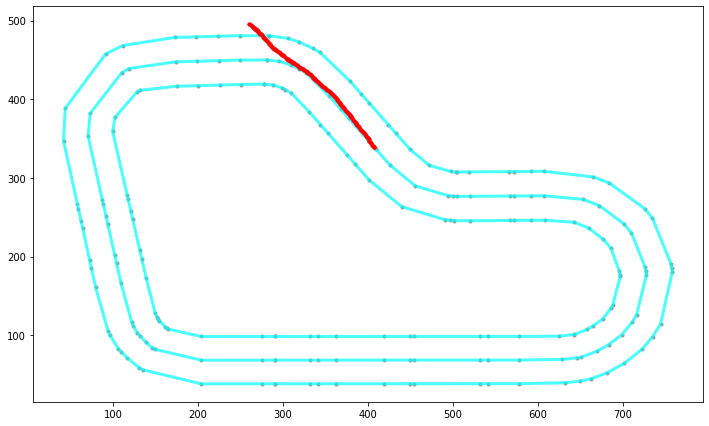

In [26]:
plot_episode_run(df, E=30) # arbitrary episode

### Path taken in a particular Iteration

/home/ccsantos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


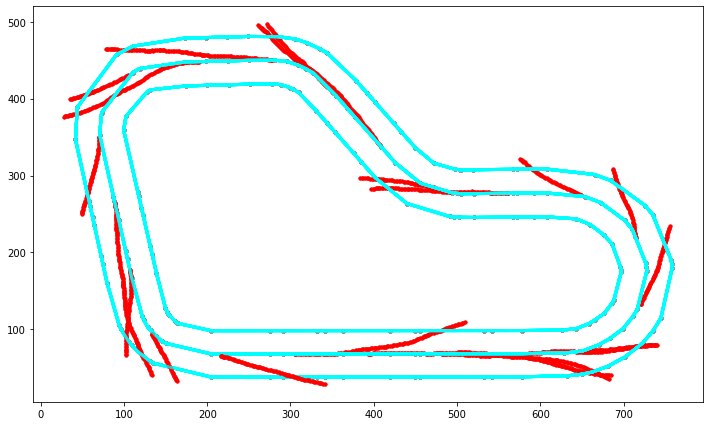

In [27]:
iteration_id = 2

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df, E=i)

## Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration.

** NOTE: This is only supported for reinvent track currently **

Number of steps in iteration= 1797


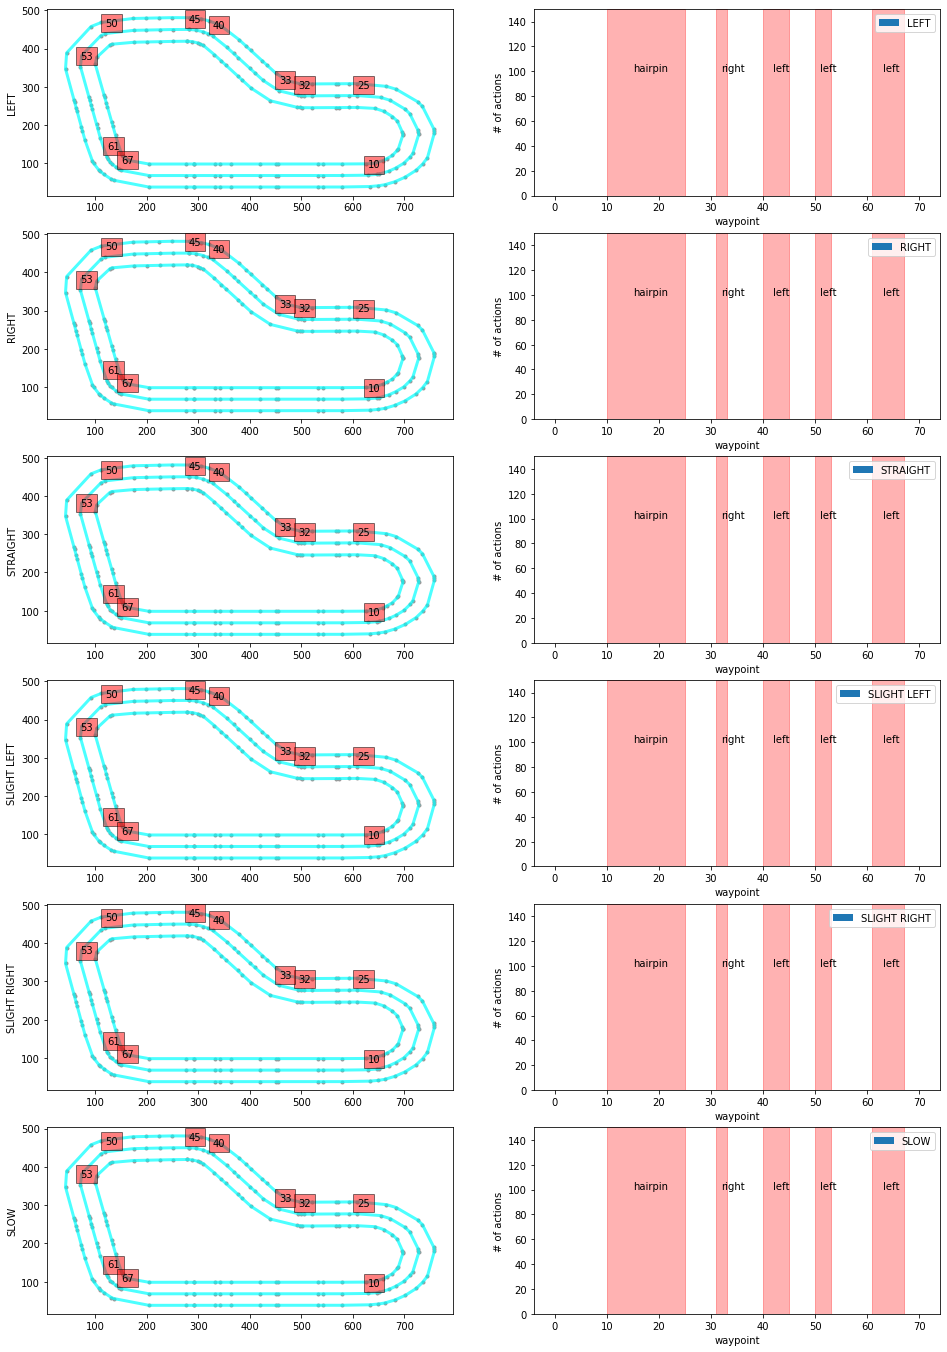

In [28]:
fig = plt.figure(figsize=(16, 24))
iterations_downselect = [iteration_id] ## Lets pick the iteratons with the highest rewards

# Track Segment Labels
action_names = ['LEFT', 'RIGHT', 'STRAIGHT', 'SLIGHT LEFT', 'SLIGHT RIGHT', 'SLOW']
vert_lines = [10,25,32,33,40,45,50,53,61,67]
track_segments = [(15, 100, 'hairpin'),
                  (32, 100, 'right'),
                  (42, 100, 'left'),
                  (51, 100, 'left'),
                  (63, 100, 'left')]

segment_x = np.array([15, 32, 42, 51, 63])
segment_y = np.array([0, 0, 0, 0, 0])

segment_xerr = np.array([[5, 1, 2, 1, 2], [10, 1, 3, 2, 4]])
segment_yerr = np.array([[0, 0, 0, 0, 0], [150, 150, 150, 150, 150]])

wpts_array = center_line 

for iter_num in iterations_downselect:

    # Slice the data frame to get all episodes in that iteration
    df_iter = df[(iter_num == df['iteration'])]
    n_steps_in_iter = len(df_iter)
    print('Number of steps in iteration=', n_steps_in_iter)

    th = 0.8
    for idx in range(len(action_names)):
        ax = fig.add_subplot(6, 2, 2*idx+1)
        print_border(ax, center_line, inner_border, outer_border) 
            
        df_slice = df_iter[df_iter['reward'] >= th]
        df_slice = df_slice[df_slice['action'] == idx]

        ax.plot(df_slice['x'], df_slice['y'], 'b.')

        for idWp in vert_lines:
            ax.text(wpts_array[idWp][0], wpts_array[idWp][1]+20, str(idWp), bbox=dict(facecolor='red', alpha=0.5))

        #ax.set_title(str(log_name_id) + '-' + str(iter_num) + ' w rew >= '+str(th))
        ax.set_ylabel(action_names[idx])

        # calculate action way point distribution
        action_waypoint_distribution = list()
        for idWp in range(len(wpts_array)):
            action_waypoint_distribution.append(len(df_slice[df_slice['closest_waypoint'] == idWp]))

        ax = fig.add_subplot(6, 2, 2 * idx + 2)

        # Call function to create error boxes
        _ = make_error_boxes(ax, segment_x, segment_y, segment_xerr, segment_yerr)

        for tt in range(len(track_segments)):
            ax.text(track_segments[tt][0], track_segments[tt][1], track_segments[tt][2])

        ax.bar(np.arange(len(wpts_array)), action_waypoint_distribution)
        ax.set_xlabel('waypoint')
        ax.set_ylabel('# of actions')
        ax.legend([action_names[idx]])
        ax.set_ylim((0, 150))

Lets analyze the hairpin turn for the best iteration. We see that the model like to take Slight left and Straight over other actions, we see that slight right and right actions frequency is very low in comparison. In short, this model seems to do well for the hairpin turn 

## Simulation Image Analysis - Probability distribution on decisions (actions)

is the model making decisions that are "too close" or is it confident for the laps it finishes. if the top and second best decisions are far apart, the model must likely be making more confident decisions 

In [29]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

In [30]:
!grep "S3 bucket" $fname
!grep "S3 prefix" $fname

S3 bucket: aws-deepracer-0366eb7d-d338-48e6-b5b3-3a1fc7e3681e
S3 prefix: DeepRacer-SageMaker-RoboMaker-comm-251199395322-20190924005043-f6135d76-0cbd-4766-93bc-4602eeece279


#### Download all the checkpoints (provided as an example).  
We recommend downloading only the ones you are interested in


In [31]:
##!aws s3 sync s3://$s3_bucket/$s3_prefix/model/ intermediate_checkpoint/ --exclude "*" --include "*model_*"

In [32]:
## For this example lets download all models in interation in the 30s

## NOTE: Copy the variables from the output of the grep command
s3_bucket = 'aws-deepracer-0366eb7d-d338-48e6-b5b3-3a1fc7e3681e'
s3_prefix = 'DeepRacer-SageMaker-RoboMaker-comm-251199395322-20190902004659-c26574ea-b98d-4e21-b794-f9d85babd2a4'
#!aws s3 sync s3://$s3_bucket/$s3_prefix/model/ intermediate_checkpoint/mytrain/v06/ --exclude "*" --include "*model_*"

In [33]:
import tensorflow as tf
import numpy as np
from tensorflow.python.platform import gfile
from PIL import Image

GRAPH_PB_PATH = 'intermediate_checkpoint/mytrain/v09/'

def load_session(pb_path):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                    log_device_placement=True))
    print("load graph:", pb_path)
    with gfile.FastGFile(pb_path,'rb') as f:
        graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    names = []
    for t in graph_nodes:
        names.append(t.name)

    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/observation/observation:0')
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    return sess, x, y

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [34]:
!ls $GRAPH_PB_PATH

Model-Final-Speed.tar.gz
model_metadata.json
model.pb
worker_0.simple_rl_graph_0.json
worker_0.simple_rl_graph.main_level.main_level.agent_0.csv


In [35]:
model_inference = []
#iterations = [0,30]

#for ii in iterations:
#model, obs, model_out = load_session(GRAPH_PB_PATH + 'model_%s.pb' % ii)
model, obs, model_out = load_session(GRAPH_PB_PATH + 'model.pb')
arr = []
for f in all_files[:]:
    img = Image.open(f)
    img_arr = np.array(img)
    img_arr = rgb2gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)
    current_state = {"observation": img_arr} #(1, 120, 160, 1)
    y_output = model.run(model_out, feed_dict={obs:[img_arr]})[0]
    arr.append (y_output)

model_inference.append(arr)
model.close()
tf.reset_default_graph()

W0924 21:43:28.548460 139781906474816 deprecation.py:323] From <ipython-input-33-88b373451956>:12: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.


load graph: intermediate_checkpoint/mytrain/v09/model.pb


(array([526., 203.,  99.,  30.,  24.,  15.,  12.,   4.,   1.,   3.]),
 array([2.2727251e-04, 6.5309629e-02, 1.3039199e-01, 1.9547433e-01,
        2.6055670e-01, 3.2563904e-01, 3.9072138e-01, 4.5580375e-01,
        5.2088612e-01, 5.8596843e-01, 6.5105081e-01], dtype=float32),
 <a list of 10 Patch objects>)

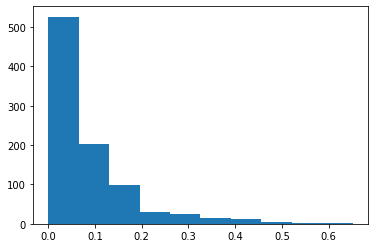

In [36]:
prob_diff = []

for mi in model_inference[0]:
    max1, max2 = mi.argsort()[-2:][::-1]
    prob_diff.append(mi[max1] - mi[max2])
plt.hist(prob_diff)

In [37]:
#prob_diff = []

#for mi in model_inference[1]:
#    max1, max2 = mi.argsort()[-2:][::-1]
#    prob_diff.append(mi[max1] - mi[max2])
#plt.hist(prob_diff)

model 36 appears to have a better seperation in probabability, hence may work better in sim2real experiments

# Model CSV Analysis


Download the model from the console AWS DeepRacer > Reinforcement learning > $Training Job Name$ > Download Model


In [38]:
fname = GRAPH_PB_PATH + 'worker_0.simple_rl_graph.main_level.main_level.agent_0.csv'
df_csv = pd.read_csv(fname) 

In [39]:
df_csv.columns

Index(['Episode #', 'Training Iter', 'In Heatup', 'ER #Transitions',
       'ER #Episodes', 'Episode Length', 'Total steps', 'Epsilon',
       'Shaped Training Reward', 'Training Reward', 'Update Target Network',
       'Wall-Clock Time', 'Evaluation Reward', 'Shaped Evaluation Reward',
       'Success Rate', 'Loss/Mean', 'Loss/Stdev', 'Loss/Max', 'Loss/Min',
       'Learning Rate/Mean', 'Learning Rate/Stdev', 'Learning Rate/Max',
       'Learning Rate/Min', 'Grads (unclipped)/Mean',
       'Grads (unclipped)/Stdev', 'Grads (unclipped)/Max',
       'Grads (unclipped)/Min', 'Discounted Return/Mean',
       'Discounted Return/Stdev', 'Discounted Return/Max',
       'Discounted Return/Min', 'Entropy/Mean', 'Entropy/Stdev', 'Entropy/Max',
       'Entropy/Min', 'Advantages/Mean', 'Advantages/Stdev', 'Advantages/Max',
       'Advantages/Min', 'Values/Mean', 'Values/Stdev', 'Values/Max',
       'Values/Min', 'Value Loss/Mean', 'Value Loss/Stdev', 'Value Loss/Max',
       'Value Loss/Min', 'Po

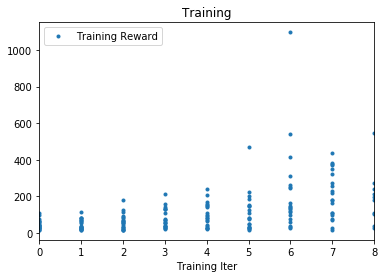

In [40]:
title = "Training"
df_csv.plot(x='Training Iter', y='Training Reward', style='.', 
        title=title)

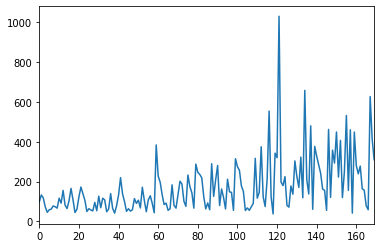

In [41]:
df_csv['Episode Length'].plot()

## Evaluation Run Analyis

Debug your evaluation runs or analyze the laps

In [42]:
eval_sim = AWS_eval_ID
eval_fname = 'deepracer-eval-%s.log' % eval_sim
cw_utils.download_log(eval_fname, stream_prefix=eval_sim)

Log file exists, use force=True to download again


In [43]:
!head $eval_fname

RoboMaker Log Recorder Starting...
+ exec stdbuf -oL -eL roslaunch deepracer_simulation_environment evaluation.launch
Checking log directory for disk usage. This may take awhile.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/robomaker/workspace/bundle-store/38c4c706-4898-4045-9c57-59b6b229f432/opt/install/deepracer_simulation_environment/share/deepracer_simulation_environment/launch/evaluation.launch
To check for compatibility of your document, use option --check-order.
For more infos, see http://wiki.ros.org/xacro#Processing_Order


In [44]:
#eval_fname = 'logs/deepracer-eval-sim-sample.log'
eval_data = load_data(eval_fname)
eval_df = convert_to_pandas(eval_data, None)
eval_df.head()

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp
0,1,0,0,305.00,68.32,0.0003,0.00,0.0,0.0,1.0,0,True,0.7923,0,17.67,1569291086.636211
1,1,0,1,305.01,68.32,-0.0002,0.52,0.5,8.0,1.0,0,True,0.7927,0,17.67,1569291086.9432697
2,1,0,2,305.19,68.28,-0.0024,0.52,0.5,8.0,1.0,0,True,0.8033,0,17.67,1569291086.9710975
3,1,0,3,306.22,68.15,-0.0115,0.52,0.5,8.0,1.0,0,True,0.8612,0,17.67,1569291087.037737
4,1,0,4,307.34,68.05,-0.0174,0.52,0.5,8.0,1.0,0,True,0.9244,0,17.67,1569291087.1034758


## Grid World Analysis
    Understand the speed of the car along with the path on a per episode basis. This can help you debug portions of the track where the car may not be going fast. Hence giving you hints on how to improve your reward function.

Episode #0 
151 96
Outer polygon length = 78.23 (meters)
Inner polygon length = 63.13 (meters)
Distance, lap time = 6.43 (meters), 23.82 (sec)
Average throttle, velocity = 0.76 (Gazebo), 0.27 (meters/sec)
###############################################################


Episode #1 
151 96
Outer polygon length = 78.23 (meters)
Inner polygon length = 63.13 (meters)
Distance, lap time = 6.10 (meters), 24.42 (sec)
Average throttle, velocity = 0.77 (Gazebo), 0.25 (meters/sec)
###############################################################


Episode #2 
151 96
Outer polygon length = 78.23 (meters)
Inner polygon length = 63.13 (meters)
Distance, lap time = 5.73 (meters), 23.16 (sec)
Average throttle, velocity = 0.76 (Gazebo), 0.25 (meters/sec)
###############################################################




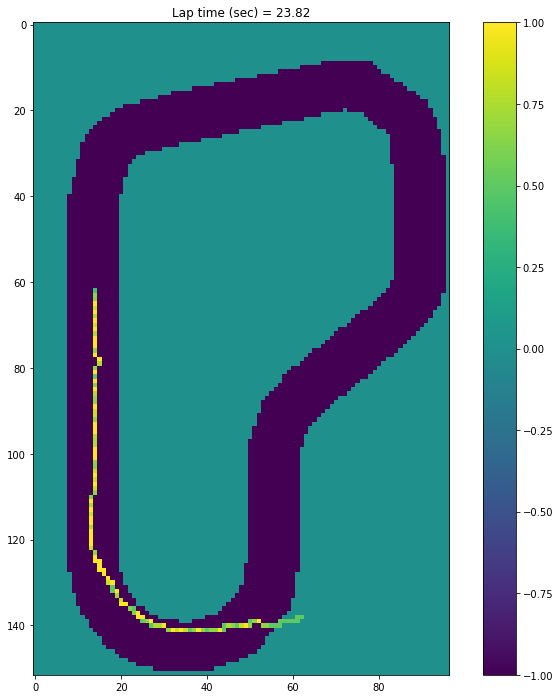

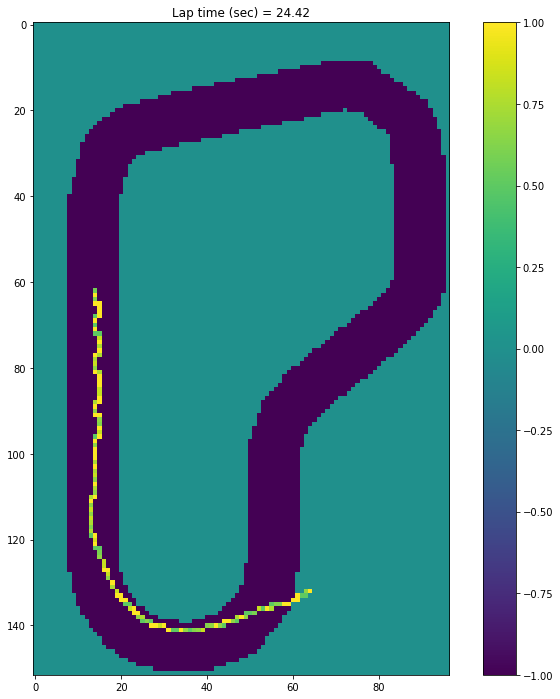

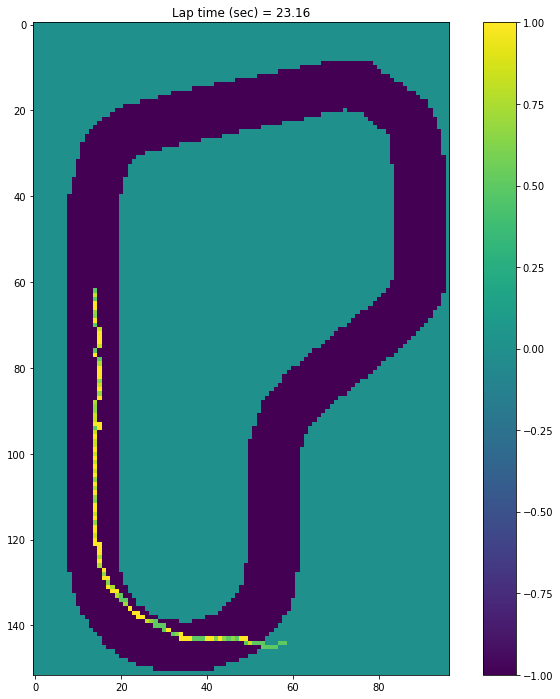

In [45]:
N_EPISODES = 3 
for e in range(N_EPISODES):
    print ("Episode #%s " %e)
    episode_df = eval_df[eval_df['episode'] == e]
    plot_grid_world(episode_df, inner_border, outer_border, scale=5.0)
    print ("###############################################################\n\n")


## What is the model looking at?

Gradcam: visual heatmap of where the model is looking to make its decisions. based on https://arxiv.org/pdf/1610.02391.pdf

In [46]:
import cv2
import numpy as np
import tensorflow as tf

def visualize_gradcam_discrete_ppo(sess, rgb_img, category_index=0, num_of_actions=6):
    '''
    @inp: model session, RGB Image - np array, action_index, total number of actions 
    @return: overlayed heatmap
    '''
    
    img_arr = np.array(img)
    img_arr = rgb2gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)
    
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/observation/observation:0')
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    feed_dict = {x:[img_arr]}

    #Get he policy head for clipped ppo in coach
    model_out_layer = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    loss = tf.multiply(model_out_layer, tf.one_hot([category_index], num_of_actions))
    reduced_loss = tf.reduce_sum(loss[0])
    conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/observation/Conv2d_4/Conv2D:0')
    grads = tf.gradients(reduced_loss, conv_output)[0]
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.sum(weights * output, axis=3)

    ##im_h, im_w = 120, 160##
    im_h, im_w = rgb_img.shape[:2]

    cam = cams[0] #img 0
    image = np.uint8(rgb_img[:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv2.resize(cam, (im_w, im_h)) # zoom heatmap
    cam = np.maximum(cam, 0) # relu clip
    heatmap = cam / np.max(cam) # normalize
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # grayscale to color
    cam = np.float32(cam) + np.float32(image) # overlay heatmap
    cam = 255 * cam / (np.max(cam) + 1E-5) ##  Add expsilon for stability
    cam = np.uint8(cam)[:, :, ::-1] # to RGB

    return cam

In [47]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

In [48]:
model_path = GRAPH_PB_PATH + 'model.pb' #Change this to your model 'pb' frozen graph file

model, obs, model_out = load_session(model_path)
heatmaps = []
for f in all_files[:5]:
    img = np.array(Image.open(f))
    heatmap = visualize_gradcam_discrete_ppo(model, img, category_index=0, num_of_actions=10)
    heatmaps.append(heatmap)
tf.reset_default_graph()

load graph: intermediate_checkpoint/mytrain/v09/model.pb


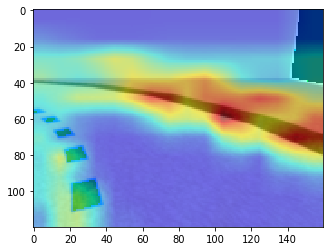

In [49]:
plt.imshow(heatmaps[0])